In [1]:
import sys
sys.path.insert(0, '../../')

In [2]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from holisticai.datasets import load_adult
from holisticai.explainability import Explainer
from holisticai.efficacy.metrics import classification_efficacy_metrics

In [3]:
from holisticai.datasets import load_adult

# Dataset
dataset = load_adult()

# Dataframe
df = pd.concat([dataset["data"], dataset["target"]], axis=1)
df = df.iloc[:500, :]
protected_variables = ["sex", "race"]
output_variable = ["class"]

# Simple preprocessing
y = df[output_variable].replace({">50K": 1, "<=50K": 0})
X = pd.get_dummies(df.drop(protected_variables + output_variable, axis=1), dtype=float)
group = ["sex"]
group_a = df[group] == "Female"
group_b = df[group] == "Male"
data = [X, y, group_a, group_b]

# Train test split
dataset = train_test_split(*data, test_size=0.2, shuffle=True)
train_data = dataset[::2]
test_data = dataset[1::2]

In [4]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
seed = np.random.seed(42) # set seed for reproducibility
# simple preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed) # train test split


model = LogisticRegression() # instantiate model
model.fit(X_train, y_train) # fit model

y_pred = model.predict(X_test) # compute predictions

# compute efficacy metrics
classification_efficacy_metrics(y_test, y_pred)

,Value,Reference
Metric,,
Accuracy,0.860000,1
Balanced Accuracy,0.697832,1
Precision,0.666667,1
Recall,0.444444,1
F1-Score,0.533333,1


# Global Explainability Metrics (based on Permutation Feature Importance)

In [35]:
# permutation feature importance
permutation_explainer = Explainer(based_on='feature_importance',
                      strategy_type='permutation',
                      model_type='binary_classification',
                      model = model, 
                      x = X_test, 
                      y = y_pred)

In [36]:
permutation_explainer.metrics(alpha=2)

ValueError: Found array with 0 feature(s) (shape=(1, 0)) while a minimum of 1 is required by check_pairwise_arrays.

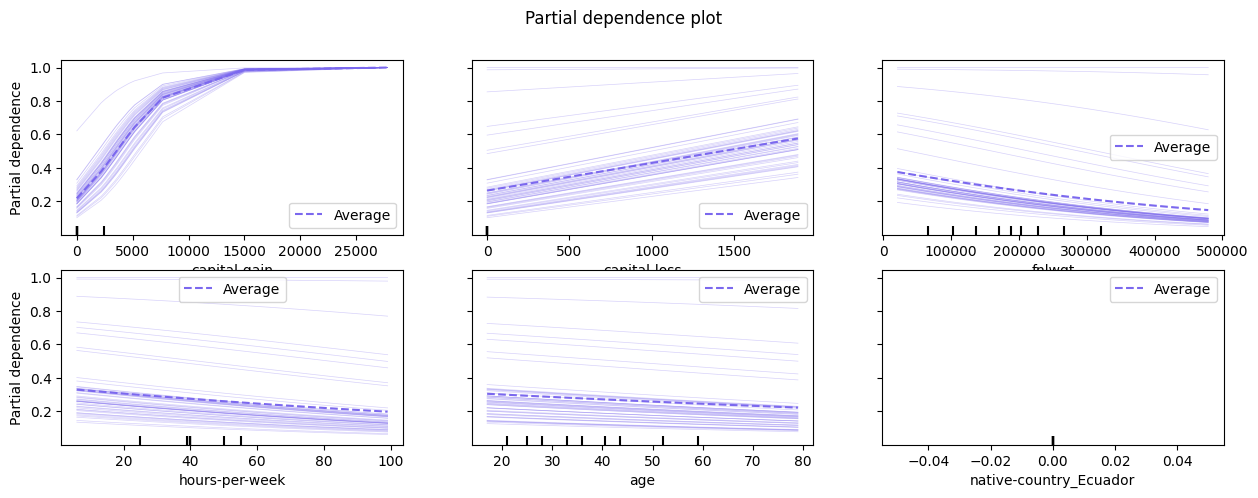

In [7]:
_,ax = plt.subplots(figsize=(15,5))
permutation_explainer.partial_dependence_plot(last=6, ax=ax, kind='both')

In [8]:
permutation_explainer.metrics(detailed=True)

,Value,Reference
Fourth Fifths,0.000000,0
Importance Spread Divergence,3.550071,-
Importance Spread Ratio,0.225715,0
Global Overlap Score [label=0],0.052831,1
Global Overlap Score [label=1],1.000000,1
Global Range Overlap Score [label=0],0.913868,1
Global Range Overlap Score [label=1],1.000000,1
Global Similarity Score [label=0],0.821415,1
Global Similarity Score [label=1],0.935700,1
Global Explainability Ease Score,1.000000,1


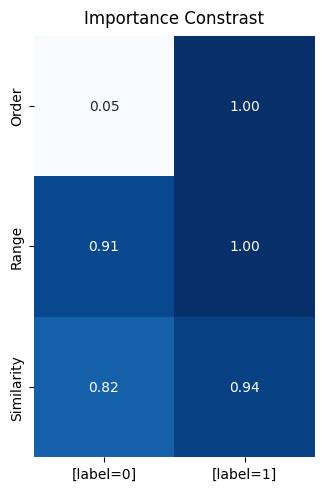

In [9]:
# Contrast Whole Importance vs. Group Importance
# -> Order -> mean positions
# -> Range -> match range of position 
# -> Similarity -> compute similarity
# -> e.g. we can see that Q0-Q1 and Q2-Q3 strong changes in their position but their importance weights maintains a high similarity with the whole model.
# -> e.g. we can see that Q1-Q2 and Q3-Q4 small changes in their position and their importance weights maintains a high similarity with the whole model.
permutation_explainer.contrast_visualization(show_connections=False)
# TODO separate show connections sin a second matrix

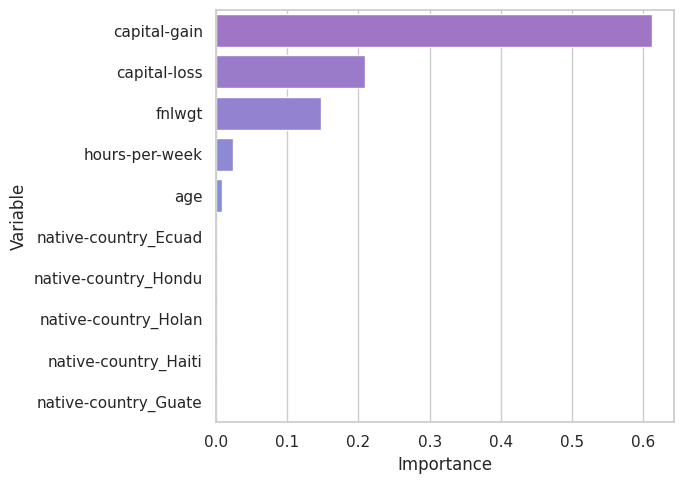

In [10]:
permutation_explainer.bar_plot(max_display=10)

In [11]:
permutation_explainer.feature_importance_table(sorted_by='Global', top_n=5)

,Global Importance,[label=0] Importance,[label=1] Importance
Variable,,,
capital-gain,0.612403,0.444444,0.382979
capital-loss,0.209302,0.000000,0.234043
fnlwgt,0.147287,0.333333,0.191489
hours-per-week,0.023256,0.222222,0.106383
age,0.007752,0.000000,0.085106


In [12]:
# surrogate feature importance
surrogate_explainer = Explainer(based_on='feature_importance',
                      strategy_type='surrogate',
                      model_type='binary_classification',
                      model = model, 
                      x = X, 
                      y = y)

In [13]:
surrogate_explainer.metrics()

,Value,Reference
Fourth Fifths,0.000000,0
Importance Spread Divergence,3.934932,-
Importance Spread Ratio,0.141775,0
Global Explainability Ease Score,1.000000,1
Surrogate Efficacy Classification,0.812000,1


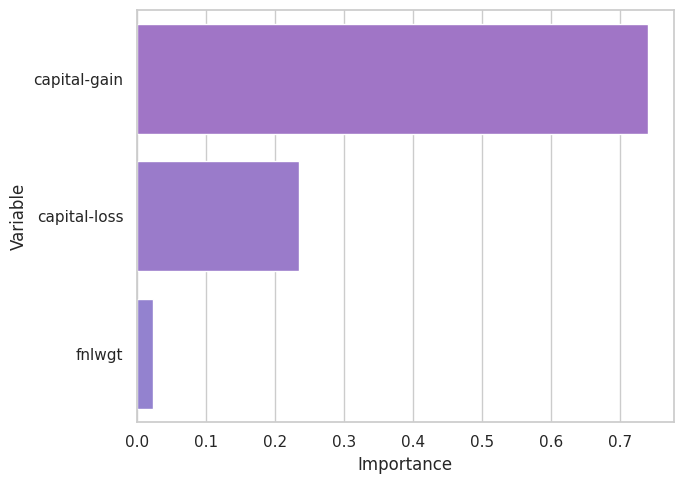

In [14]:
surrogate_explainer.bar_plot(max_display=3)

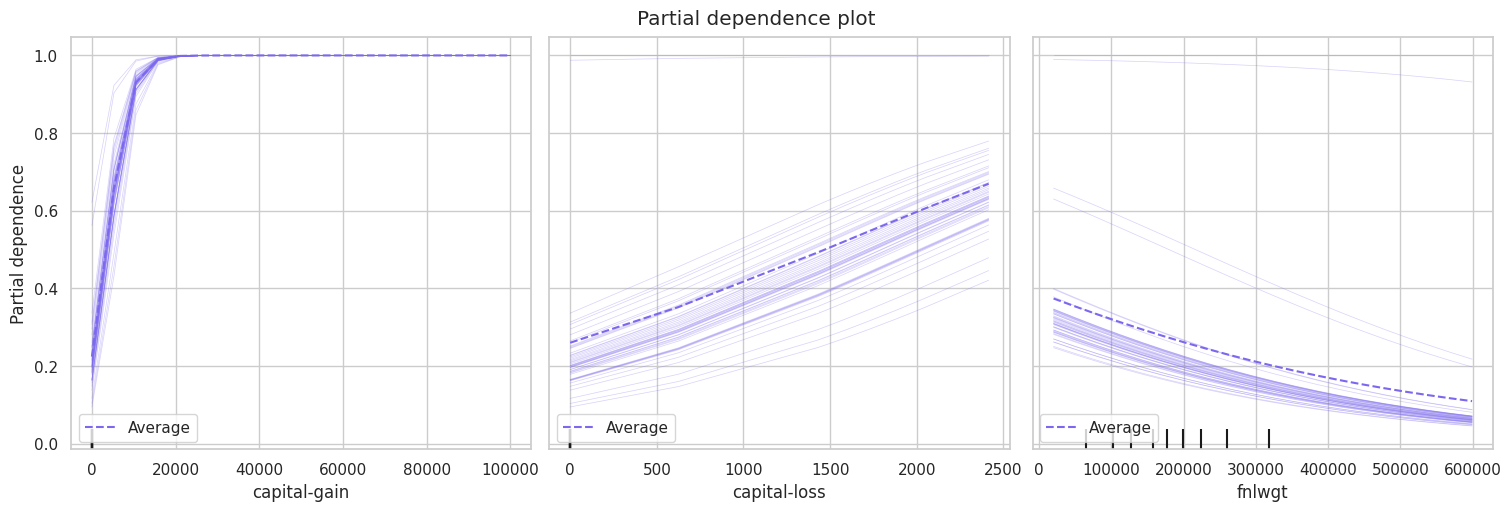

In [15]:
_,ax = plt.subplots(figsize=(15,5))
surrogate_explainer.partial_dependence_plot(last=3, ax=ax, kind='both')

In [16]:
surrogate_explainer.feature_importance_table(sorted_by='Global', top_n=10)

,Global Importance
Variable,
capital-gain,0.741089
capital-loss,0.235700
fnlwgt,0.023211
education_Preschool,0.000000
education-num,0.000000
hours-per-week,0.000000
workclass_Federal-gov,0.000000
workclass_Local-gov,0.000000
workclass_Never-worked,0.000000


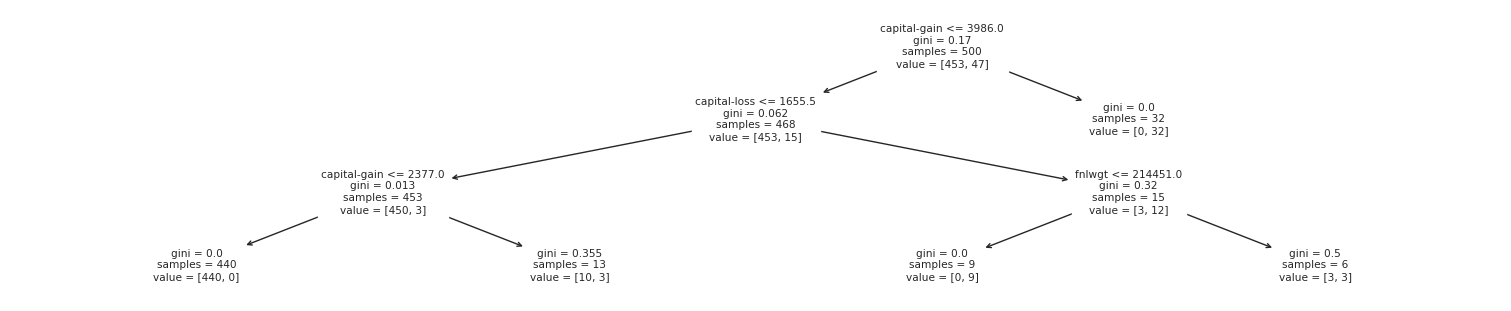

In [17]:
_,ax = plt.subplots(figsize=(15,3))
_ = surrogate_explainer.tree_visualization('sklearn', ax=ax)

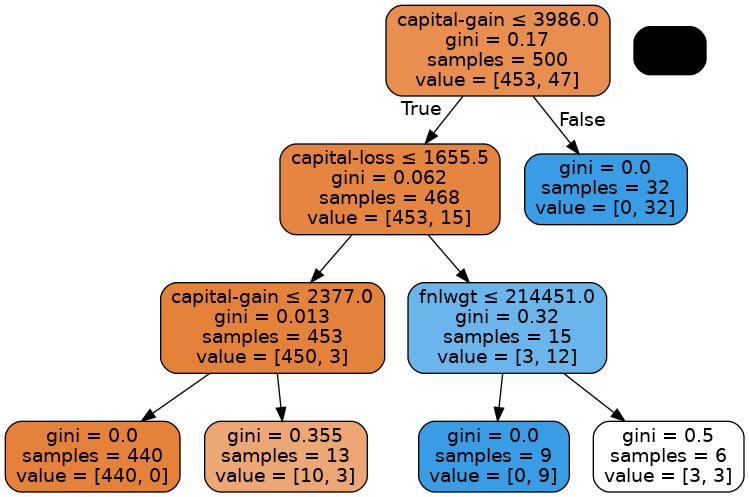

In [18]:
surrogate_explainer.tree_visualization('pydotplus')

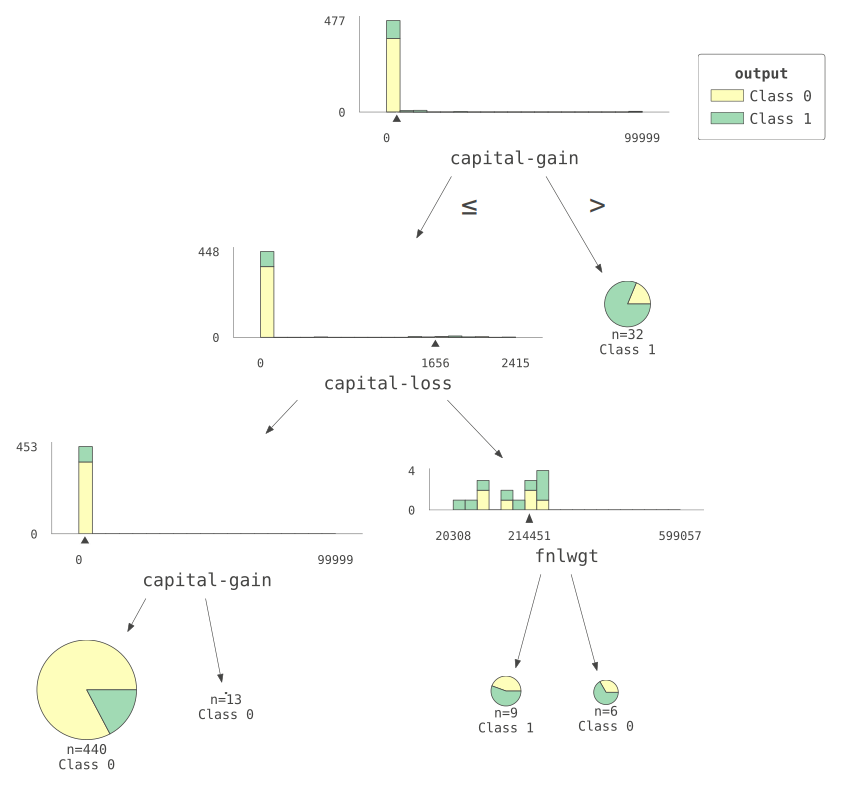

In [19]:
vis = surrogate_explainer.tree_visualization('dtreeviz', scale=2)
vis

# Local Explainability Metrics (based on Lime)

In [20]:
# lime feature importance
lime_explainer = Explainer(based_on='feature_importance',
                      strategy_type='lime',
                      model_type='binary_classification',
                      model = model, 
                      x = X, 
                      y = y)

In [21]:
lime_explainer.metrics(detailed=False)

,Value,Reference
Dataset Stability Gini,0.047940,0
Features Stability Gini,0.068569,0


In [22]:
lime_explainer.metrics(detailed=True)

,Value,Reference
Metric,,
Dataset Stability Gini,0.047940,0
Dataset Stability Gini [label=0],0.045418,0
Dataset Stability Gini [label=1],0.053044,0
Features Stability Gini,0.068569,0
Features Stability Gini [label=0],0.078339,0
Features Stability Gini [label=1],0.101359,0


In [23]:
lime_explainer['Dataset Stability Gini']

0.0479398086910206

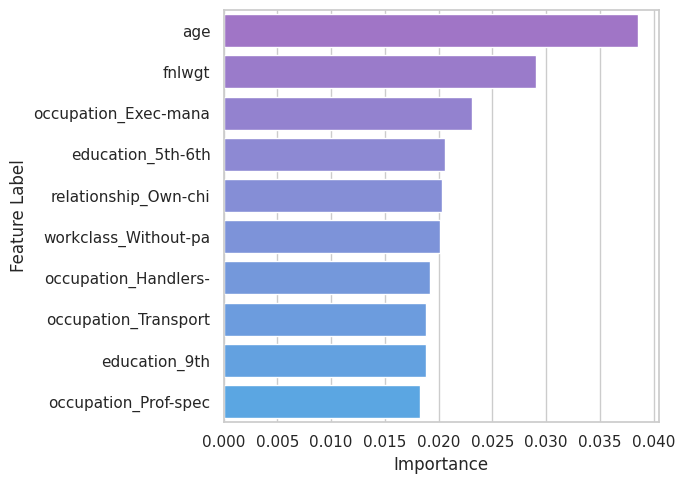

In [24]:
lime_explainer.bar_plot(max_display=10)

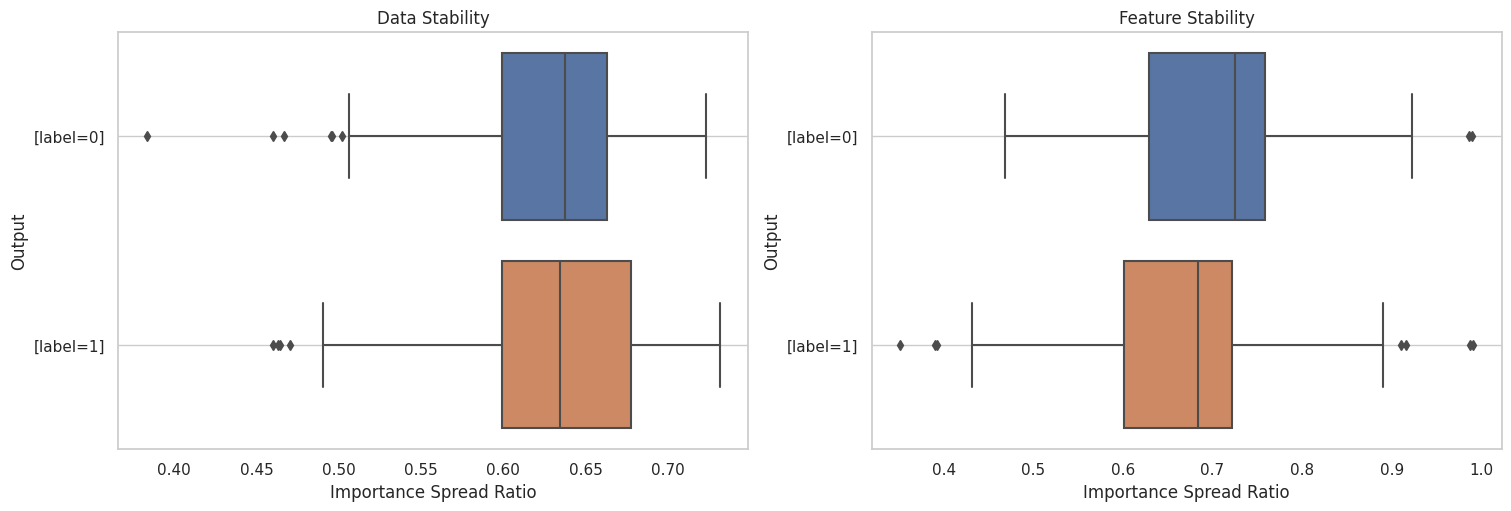

In [25]:
lime_explainer.show_importance_stability()

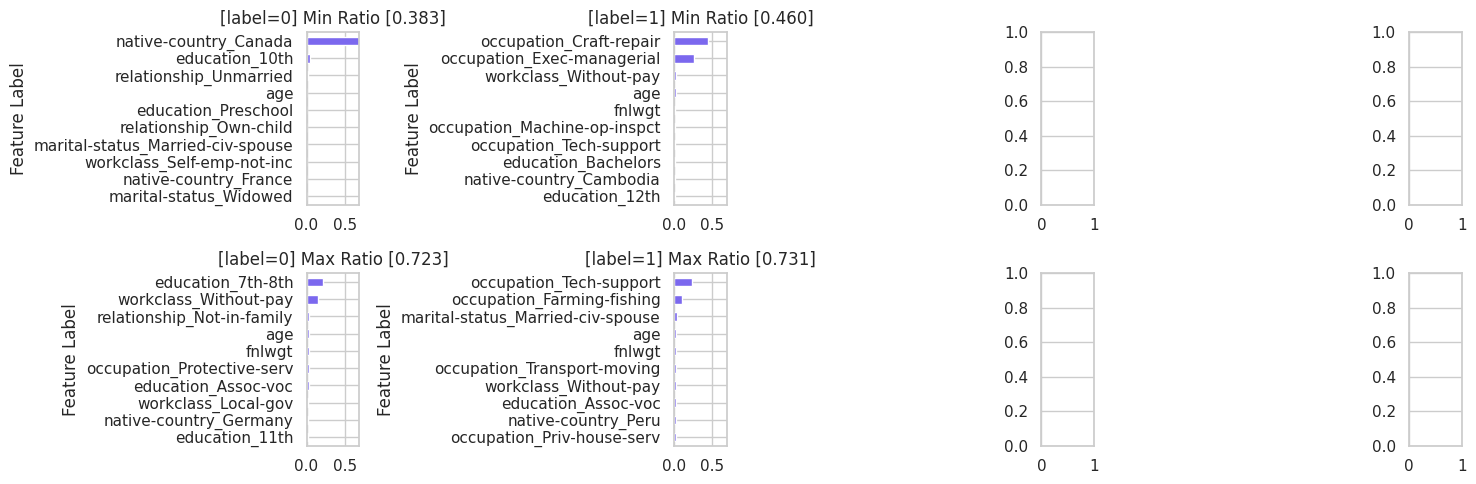

In [26]:
lime_explainer.show_data_stability_boundaries(top_n=10, figsize=(15,5))

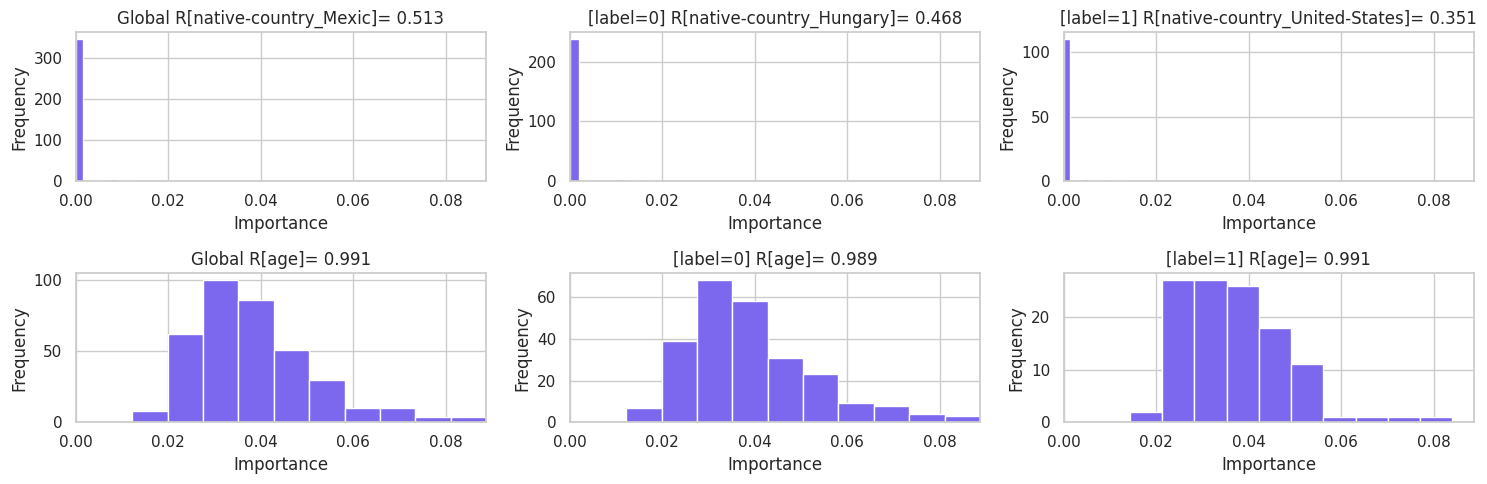

In [27]:
lime_explainer.show_features_stability_boundaries(figsize=(15,5))

# Local Explainability Metrics (SHAP)

In [28]:
# lime feature importance
shap_explainer = Explainer(based_on='feature_importance',
                      strategy_type='shap',
                      model_type='binary_classification',
                      model = model, 
                      x = X, 
                      y = y)

In [29]:
shap_explainer.metrics(detailed=False)

,Value,Reference
Dataset Stability Gini,0.126998,0
Features Stability Gini,0.105052,0


In [30]:
shap_explainer['Dataset Stability Gini']

0.1269980597729367

In [31]:
shap_explainer.metrics(detailed=True)

,Value,Reference
Metric,,
Dataset Stability Gini,0.126998,0
Dataset Stability Gini [label=0],0.074865,0
Dataset Stability Gini [label=1],0.234679,0
Features Stability Gini,0.105052,0
Features Stability Gini [label=0],0.064440,0
Features Stability Gini [label=1],0.060805,0


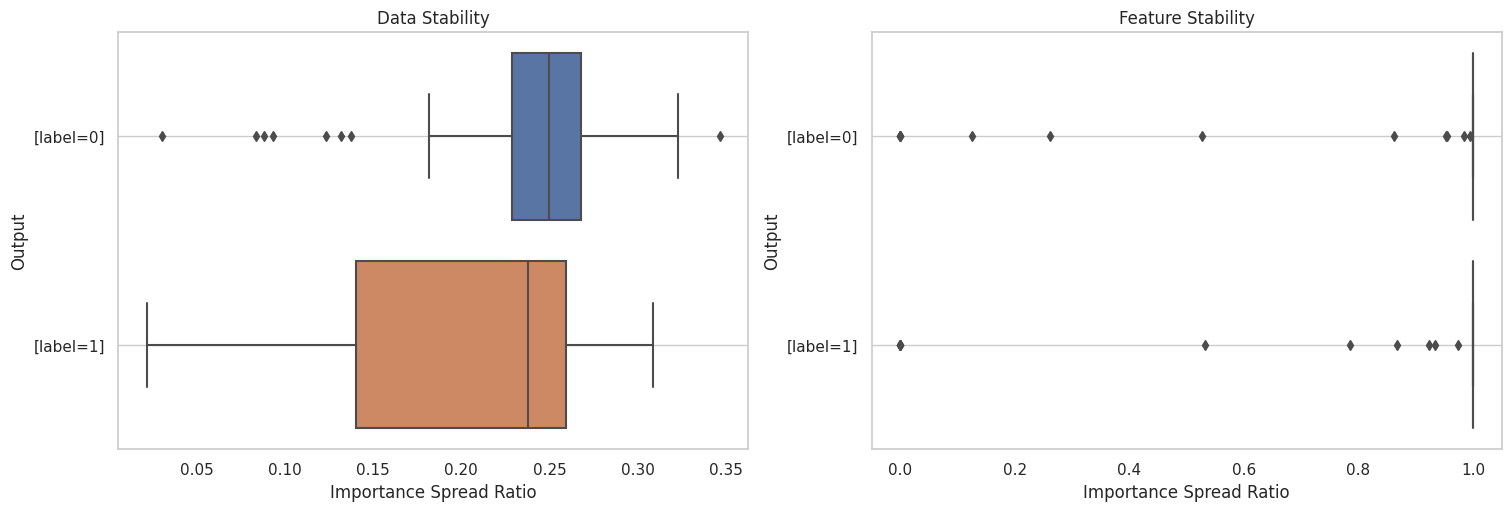

In [32]:
shap_explainer.show_importance_stability()

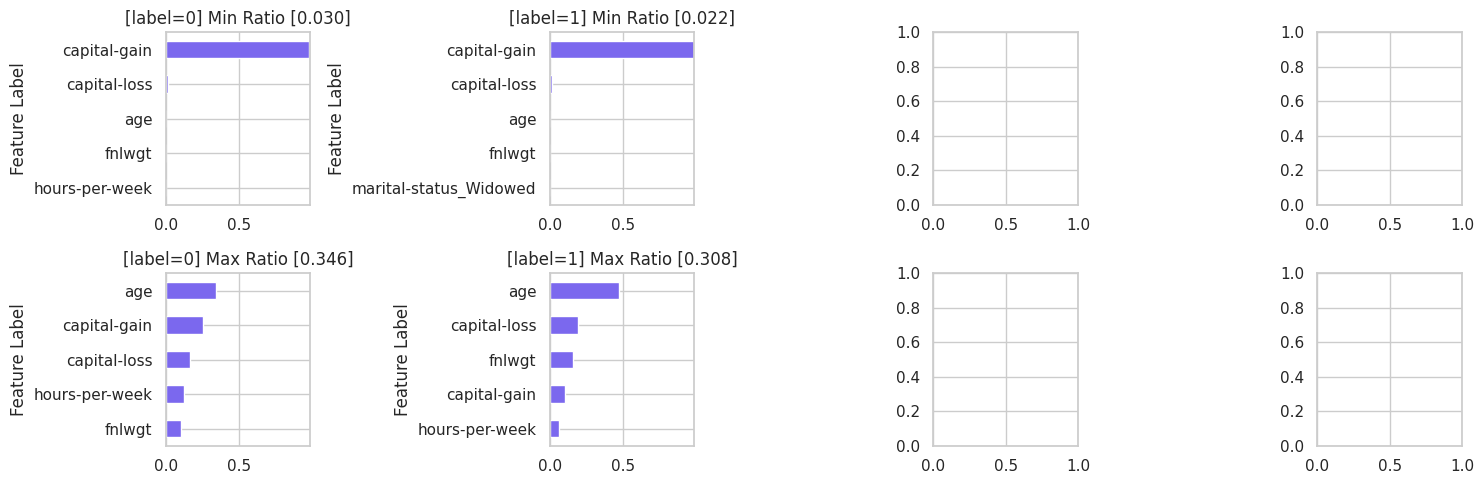

In [33]:
shap_explainer.show_data_stability_boundaries(top_n=5, figsize=(15,5))

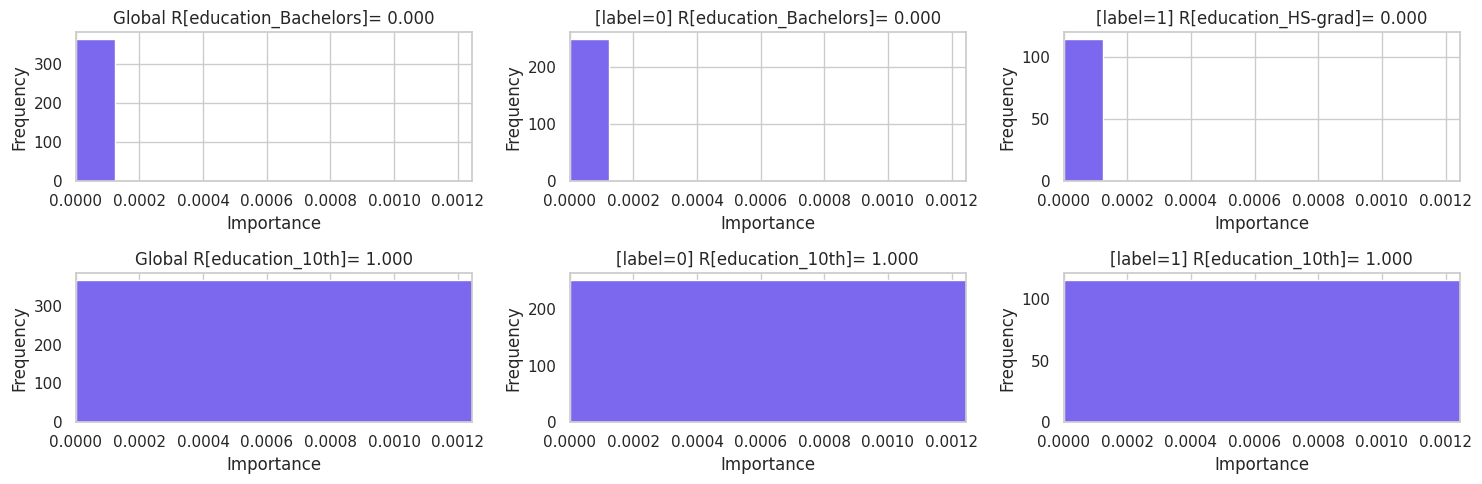

In [34]:
shap_explainer.show_features_stability_boundaries(figsize=(15,5))